In [1]:
import sys, os
sys.path.append(os.path.join(sys.path[0], "code"))

In [3]:
# Run this cell only if "from mpl_toolkits.basemap import Basemap" causes KeyError: 'PROJ_LIB'

conda_dir = "/home/USERNAME/anaconda3/envs/sinkhorn_cnf" # replace with conda environment path
proj_lib = os.path.join(conda_dir, 'bin/proj')
os.environ["PROJ_LIB"] = proj_lib

In [4]:
import pytorch_models as models
import pytorch_samplers as samplers
import pytorch_losses as losses
import pytorch_training as training
import pytorch_utils as utils
import geodesics

import importlib
import time
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.basemap import Basemap
import torch
import torch.nn as nn
import torch.nn.functional as F
from statistics import mean
from torchdiffeq import odeint
import random
import numpy as np

importlib.reload(models)
importlib.reload(losses)
importlib.reload(samplers)
importlib.reload(training)
importlib.reload(utils)
importlib.reload(geodesics)

<module 'geodesics' from '/mnt/hdd/scarv/riemannian-metric-learning-ot/code/geodesics.py'>

In [4]:
torch.set_default_dtype(torch.float64)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# Import eBird data

data_file = 'data/snow_goose/ebird_snow_goose_data_basemap.npy'
data_array = np.load(data_file, allow_pickle=True)
data_list = list(data_array)

In [6]:
start_month = 0
end_month = 6
data_list_spring = data_list[start_month:end_month]

elapsed time: 258.4296329021454 s.
[ 0.          0.4137931   0.82758621  1.24137931  1.65517241  2.06896552
  2.48275862  2.89655172  3.31034483  3.72413793  4.13793103  4.55172414
  4.96551724  5.37931034  5.79310345  6.20689655  6.62068966  7.03448276
  7.44827586  7.86206897  8.27586207  8.68965517  9.10344828  9.51724138
  9.93103448 10.34482759 10.75862069 11.17241379 11.5862069  12.        ]


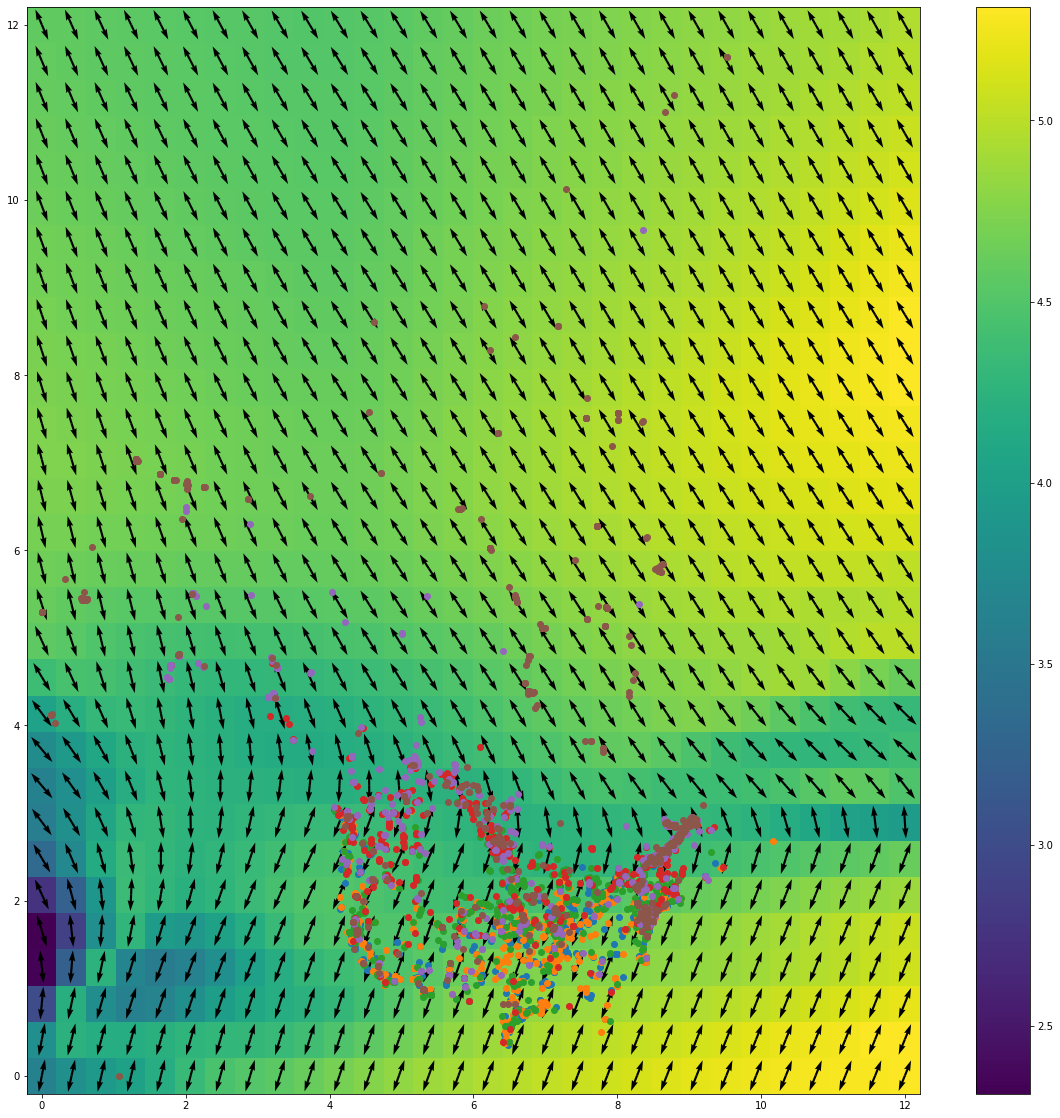

In [7]:
# Learn metric tensor from eBird data

seed = 0
n_samples = 500
space_dims = 2
scalar_hidden_dims = 32
matrix_hidden_dims = 32
gp_strength_phi = 1e-6
gp_strength_R = 1e0
fro_reg_strength = 1e9
identity_reg_strength = 0
lr = 1e-2
weight_decay = 1e-2
n_epochs_phi = 500
n_epochs_R = 10000
R_model_type = "multilayer"

t0 = time.time()
ebird_learnedA, phi_list, rho_0_list, rho_1_list = training.twostep_train_wot_model(data_list_spring,
                                                                                    n_samples,
                                                                                    scalar_hidden_dims,
                                                                                    matrix_hidden_dims,
                                                                                    fro_reg_strength,
                                                                                    identity_reg_strength,
                                                                                    gp_strength_phi,
                                                                                    gp_strength_R,
                                                                                    lr,
                                                                                    weight_decay,
                                                                                    n_epochs_phi,
                                                                                    n_epochs_R,
                                                                                    seed,
                                                                                    R_model_type
                                                                                   )

t1 = time.time()
print('elapsed time: ' + str(t1-t0) + ' s.')

# Plot eigenvectors of metric
plt.figure(figsize=(20,20))
# Eigs plot params
x_lims = (0,12)
y_lims = (0,12)
n = 30
utils.eigs_quiver(ebird_learnedA, n, x_lims, y_lims)
for t in range(len(data_list_spring)):
    plt.scatter(data_list_spring[t][:,0], data_list_spring[t][:,1])

In [8]:
# Save the learned metric

ebird_learnedA_path = "trained_models/ebird_learnedA_params.pt"
torch.save(ebird_learnedA.state_dict(), ebird_learnedA_path)

In [9]:
# Carry out trajectory inference for each snow goose in Banks Island SNGO study

goose_id_list = [82901, 82902, 82905, 82906, 82907, 82908, 82909, 82910]
t_inits = [20000, 0, 0, 20000, 0, 0, 0, 0]
t_finals = [26000, 9100, 15057, 26500, 9000, 13037, 7200, 10000]
lambds = [5e1, 5e1, 1e2, 5e1, 1e2, 5e1, 5e1, 1e2]

for i, goose_id in enumerate(goose_id_list):
    fname = "data/snow_goose/movebank_goose_data_basemap_" + str(goose_id) + ".npy"
    true_path = np.load(fname, allow_pickle=True)
    t_init = t_inits[i]
    t_final = t_finals[i]
    
    x_0 = torch.from_numpy(true_path[t_init]).to(device)
    x_1 = torch.from_numpy(true_path[t_final]).to(device)
    n_times = 32
    t = torch.linspace(0, 1, n_times, device=device)
    lambd = lambds[i]
    x_t, losses = geodesics.compute_A_geodesic(x_0, x_1, ebird_learnedA, t, lambd)
    # Save the trajectory x_t
    fname = "results/snow_goose_experiments/final_goose_inferred_traj_2197-" + str(goose_id) + ".npy"
    np.save(fname, x_t.detach().cpu().numpy())

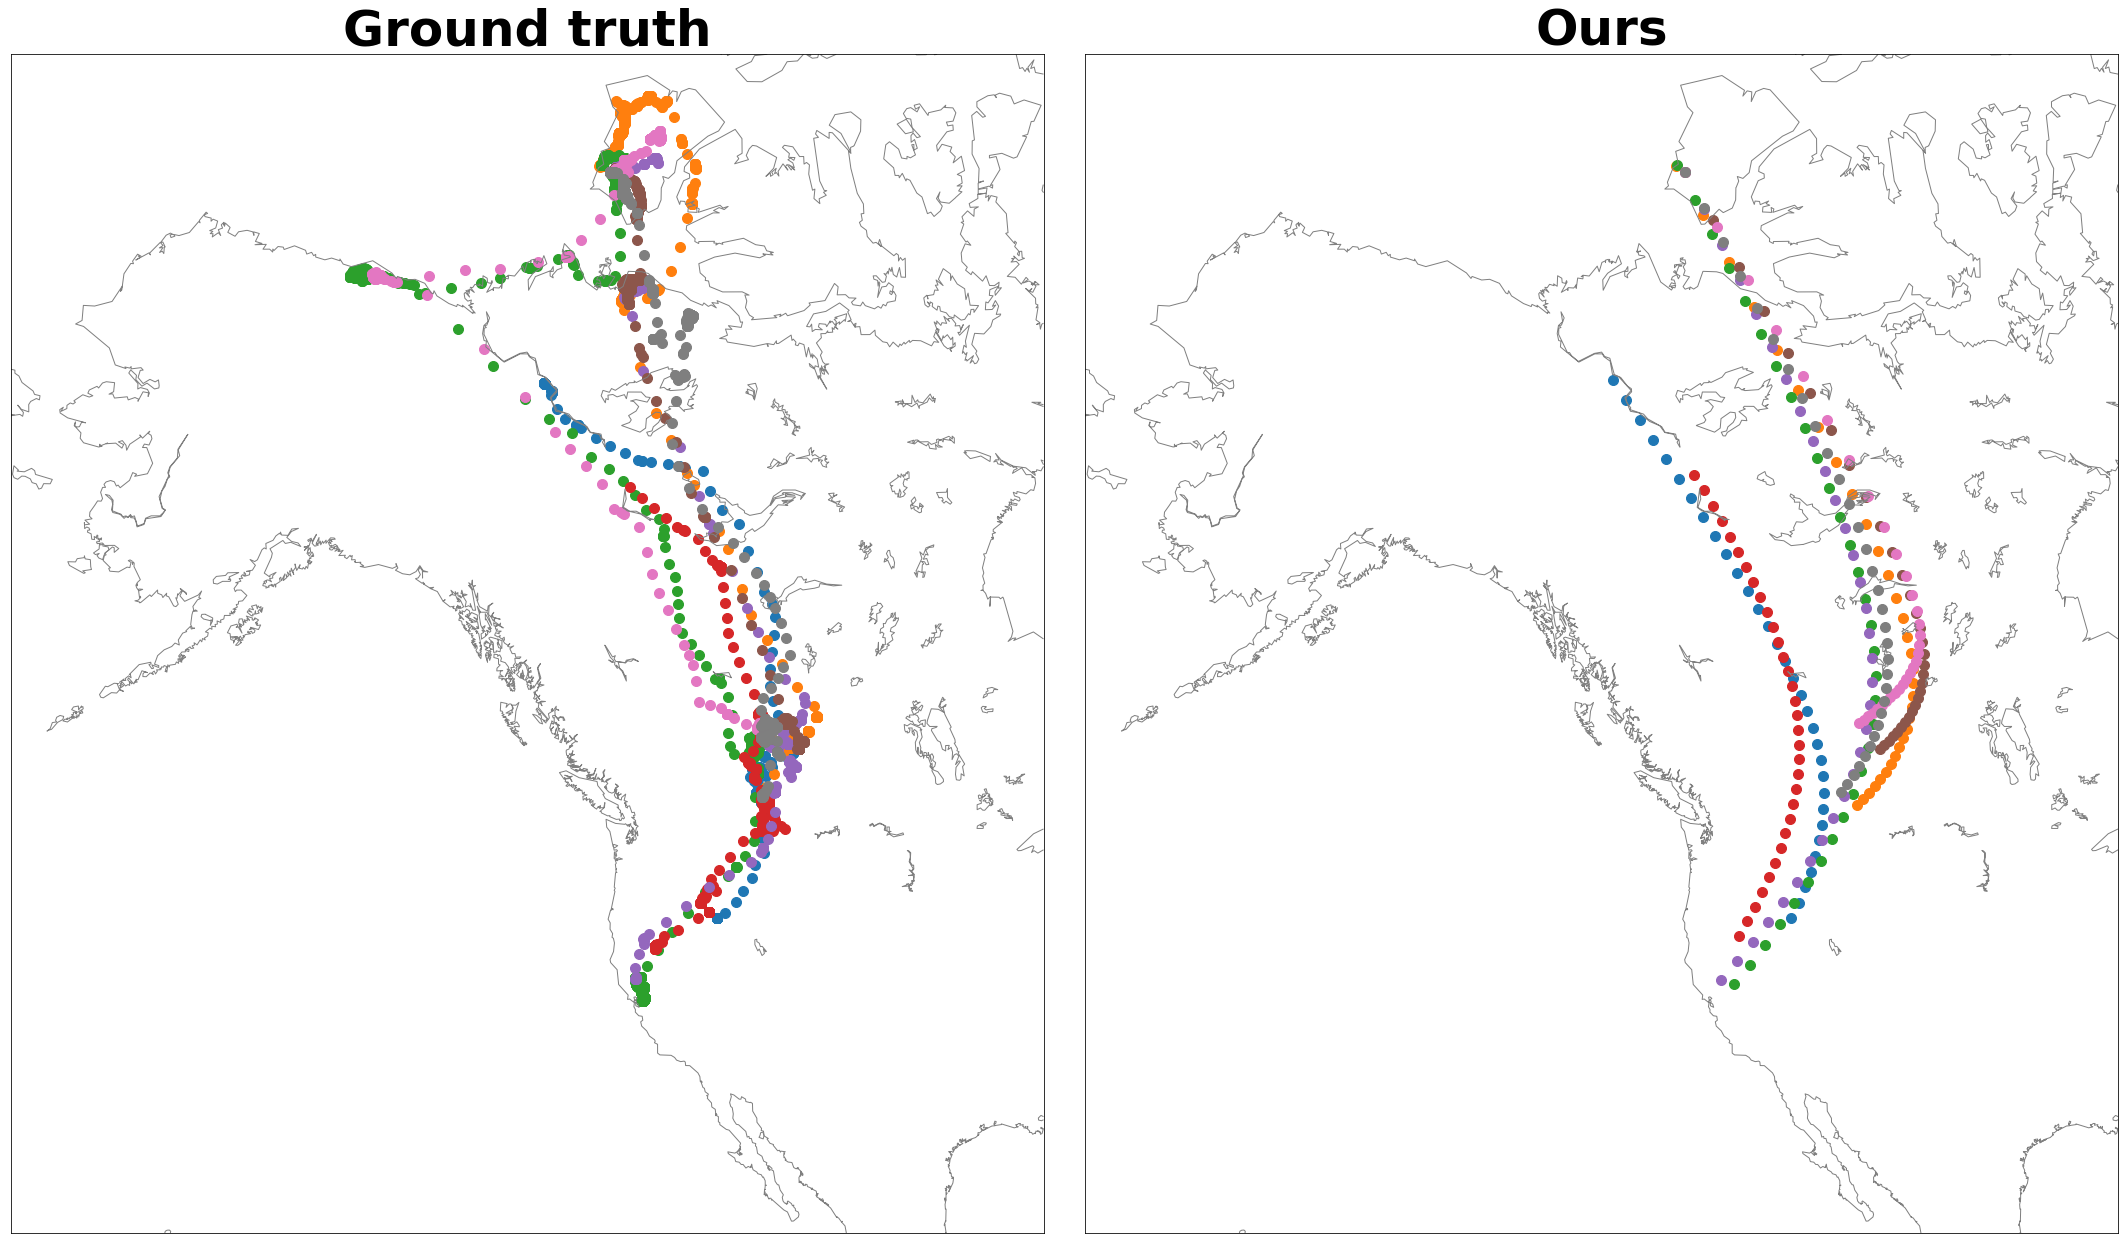

In [10]:
# Plot the ground truth trajectories on LHS and inferred trajectories on RHS

fig = plt.figure(figsize=(30,20))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig.tight_layout()

llcrnrlat = 22
llcrnrlon = -172
urcrnrlat = 75
urcrnrlon = -90

m = Basemap(projection='merc',llcrnrlat=llcrnrlat,urcrnrlat=urcrnrlat,
            llcrnrlon=llcrnrlon,urcrnrlon=urcrnrlon, suppress_ticks=True, rsphere=5, resolution='l')

# Draw map outline
m.drawcoastlines(ax=ax1, color='gray')
m.drawcoastlines(ax=ax2, color='gray')

# Now load each ground truth trajectory and plot on LHS
goose_id_list = [82901, 82902, 82905, 82906, 82907, 82908, 82909, 82910]
t_inits = [20000, 0, 0, 20000, 0, 0, 0, 0]
t_finals = [26000, 9100, 15057, 26500, 9000, 13037, 7201, 10000]
for i, goose_id in enumerate(goose_id_list):
    fname = "data/snow_goose/movebank_goose_data_basemap_" + str(goose_id) + ".npy"
    true_path = np.load(fname, allow_pickle=True)
    t_init = t_inits[i]
    t_final = t_finals[i]
    x = true_path[t_init:t_final,0]
    y = true_path[t_init:t_final,1]
    ax1.scatter(x[::5], y[::5], marker="o", s=100)
    
# Now load each inferred trajectory and plot on LHS
goose_id_list = [82901, 82902, 82905, 82906, 82907, 82908, 82909, 82910]
for i, goose_id in enumerate(goose_id_list):
    fname = "results/snow_goose_experiments/final_goose_inferred_traj_2197-" + str(goose_id) + ".npy"
    inferred_path = np.load(fname, allow_pickle=True)
    ax2.scatter(inferred_path[:,0], inferred_path[:,1], marker="o", s=100)

ax1.set_title("Ground truth", fontsize=50, fontweight="bold")
ax2.set_title("Ours", fontsize=50, fontweight="bold")

# Save figure
plt.savefig("results/sngo_traj_plots_horizontal.png", dpi=300, bbox_inches="tight")